In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [54]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode", "TransactionGroup"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-972.619715
2013-12-30,-75.956876
2013-12-30,127.430470
2013-12-30,-38.300469
2013-12-30,-117.467137
...,...
2020-12-31,-19.288367
2020-12-31,-832.837608
2020-12-31,-103.691425


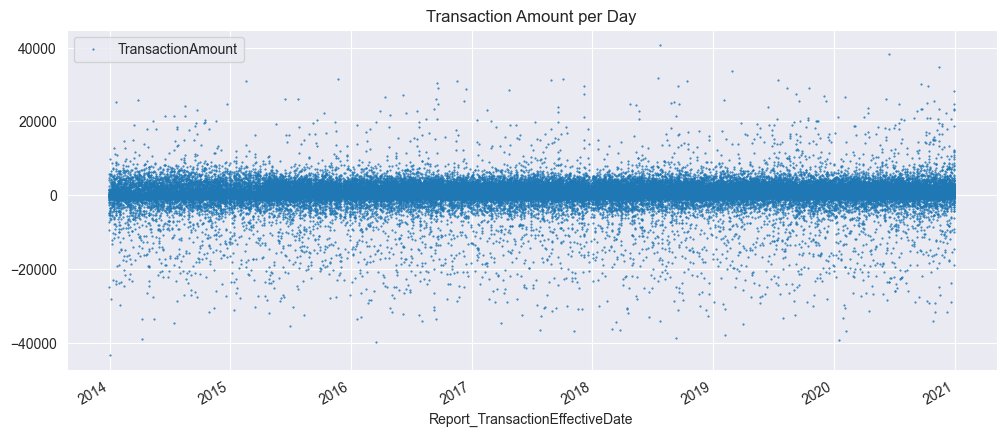

In [55]:
colour_pal = sns.color_palette()
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Transaction Amount per Day" )
plt.show()

In [56]:
## Total Transaction value per day
df = df.groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D').fillna(0).to_frame()
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-45506.653405
2014-01-03,-18386.381900
...,...
2020-12-27,0.000000
2020-12-28,0.000000
2020-12-29,82156.304473


In [57]:
# Check for extreme outliers
q1, q3 = df['TransactionAmount'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['TransactionAmount'] < lower_bound) | (df['TransactionAmount'] > upper_bound)]
print("Outliers detected:", len(outliers))

Outliers detected: 105


In [58]:
df['TransactionAmount'] = np.clip(df['TransactionAmount'], lower_bound, upper_bound)


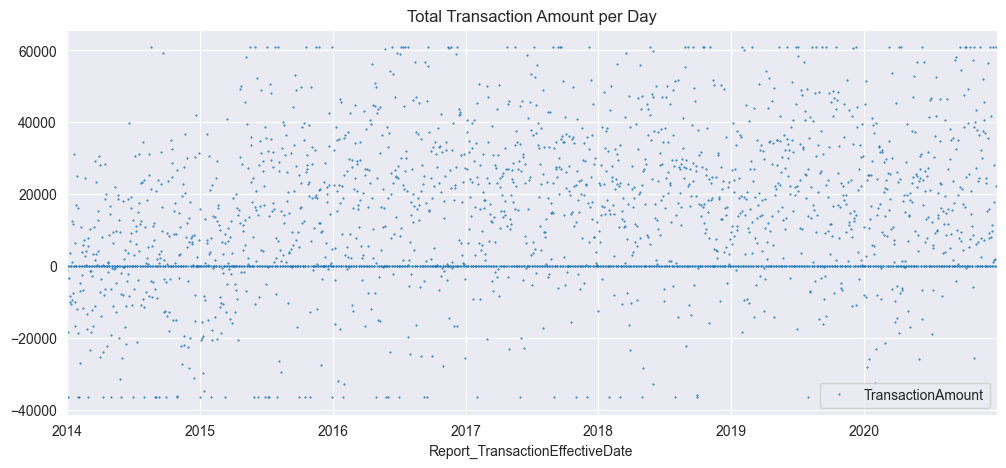

In [59]:
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Total Transaction Amount per Day" )
plt.show()

In [60]:
def create_features(df, label):
    # Create time-based features
    df = df.copy()
    df['date'] = df.index
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayname'] = df['date'].dt.day_name()
    df['quarter'] = df['date'].dt.quarter

    X = df[['year', 'month', 'day', 'dayofweek', 'quarter', "dayname"]]

    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label="TransactionAmount")
features_and_target = pd.concat([X, y], axis=1)
ft = features_and_target[features_and_target["dayname"] == 'Sunday']
ft[ft["TransactionAmount"] != 0]

,year,month,day,dayofweek,quarter,dayname,TransactionAmount
Report_TransactionEffectiveDate,,,,,,,
2014-08-31,2014,8,31,6,3,Sunday,-6468.640324
2014-11-30,2014,11,30,6,4,Sunday,-22619.944838
2015-05-31,2015,5,31,6,2,Sunday,-10601.071575
2016-01-31,2016,1,31,6,1,Sunday,-32952.634740
2016-07-31,2016,7,31,6,3,Sunday,-24459.850071
2016-12-25,2016,12,25,6,4,Sunday,710.802335
2017-04-30,2017,4,30,6,2,Sunday,-23042.087158
2017-12-31,2017,12,31,6,4,Sunday,-12680.691034
2018-09-30,2018,9,30,6,3,Sunday,-36536.250323


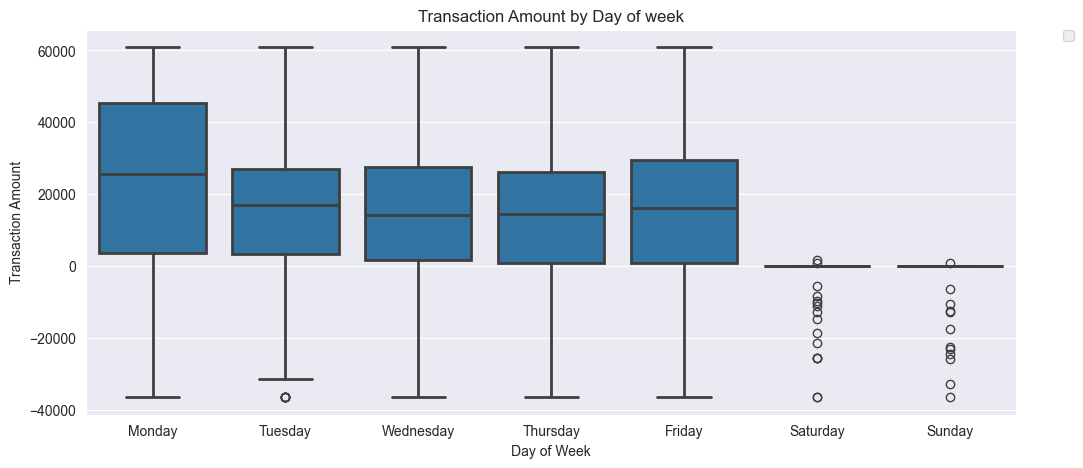

In [61]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x="dayname", y="TransactionAmount", data=features_and_target, ax=ax, linewidth=2)
ax.set_title("Transaction Amount by Day of week")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Transaction Amount")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()